In [33]:
# Import some useful libraries
import sys, os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

## Part 2: SCA on ECC implementation
In part 2, we implement a template attack against Elliptic-Curve Cryptography (ECC) implemented on ARM Cortex-M4. The algorithm used is Ed25519 (the EdDSA with the parameters of Curve25519 is referred to as Ed25519).

EdDSA is a variant of the Schnorr digital signature scheme using Twisted Edward Curves, a subgroup of elliptic curves that uses unified formulas, enabling speed-ups for specific curve parameters. This algorithm proposes a deterministic generation of the ephemeral key, different for every message, to prevent flaws from a biased random number generator.
The ephemeral key $r$ is made of the hash value of the message $M$ and the auxiliary key $b$, generating a unique ephemeral public key $R$ for every message.
In this attack, we focus on recovering the ephemeral key by using only one trace of the full scalar multiplication.

The implementation of Ed25519 on Cortex-M4 is a window-based method with radix-16, making use of a precomputed table containing results of the scalar multiplication of $16^i |r_i| \cdot G$, where $r_i\in [-8,7]\cap \mathbb{Z}$ and $G$ is the base point of Curve25519.

To recover the complete key, we will need to operate in the dive-and-conquer approach and recover the 16 parts of the ephemeral key associated with each iteration of the scalar multiplication.

The trace set contains different iterations of the scalar multiplication.
The traceset (78MB) (6\,400 traces, 1k samples each) can be downloaded [here](https://github.com/leoweissbart/MachineLearningBasedSideChannelAttackonEdDSA/raw/master/databaseEdDSA.h5).
The traceset is divided in ['Attack\_traces', 'Profiling\_traces'] and each set contains ['traces', 'label'] containing traces with associated labels. 

### 1) Load dataset

In [111]:
### Load dataset
datasetFileName = os.getcwd() + '/databaseEdDSA.h5'
f = h5py.File(datasetFileName,'r')
train_data = np.array(f['Profiling_traces/traces'])
train_targets = np.array(f['Profiling_traces/label'])
test_data = np.array(f['Attack_traces/traces'])
test_targets = np.array(f['Attack_traces/label'])

# Print the shape of the loaded data
print("Training data shape: ", train_data.shape)
print("Training labels shape: ", train_targets.shape)
print("Test data shape: ", test_data.shape)
print("Test labels shape: ", test_targets.shape)
print("Total number of traces: ", train_data.shape[0] + test_data.shape[0])
print("Total number of classes: ", len(np.unique(train_targets)))

# Print the test targets to verify the data in hexadecimal format
print("Test targets: ", [hex(t) for t in test_targets])

Training data shape:  (5120, 1000)
Training labels shape:  (5120,)
Test data shape:  (1280, 1000)
Test labels shape:  (1280,)
Total number of traces:  6400
Total number of classes:  16
Test targets:  ['0xf', '0x0', '0xc', '0x4', '0xa', '0x3', '0xc', '0x9', '0x0', '0xa', '0x6', '0x7', '0x7', '0xd', '0xc', '0xa', '0x6', '0x6', '0x3', '0xb', '0xd', '0x3', '0x6', '0x8', '0x2', '0xa', '0xc', '0x9', '0x1', '0xc', '0x1', '0xe', '0x3', '0x1', '0x2', '0x5', '0x5', '0x7', '0x8', '0x4', '0x5', '0xc', '0x8', '0xd', '0xa', '0xb', '0x9', '0x8', '0x3', '0xa', '0x1', '0x2', '0x6', '0x7', '0x6', '0x1', '0xf', '0xe', '0xd', '0x7', '0x2', '0xc', '0x6', '0x3', '0xd', '0x2', '0xe', '0xe', '0x3', '0xb', '0xf', '0x5', '0xa', '0x6', '0x4', '0x5', '0xd', '0x7', '0x7', '0xd', '0x0', '0x2', '0x2', '0xc', '0x1', '0xa', '0x2', '0xc', '0x7', '0x5', '0xa', '0x4', '0x9', '0x0', '0xb', '0x2', '0xd', '0x0', '0xd', '0x7', '0xf', '0x2', '0x3', '0x8', '0x5', '0xc', '0x5', '0x3', '0xe', '0x1', '0x5', '0xd', '0xf', '0xf', '

### 2) Build the template
Sort the training data by class, according to the training labels (i.e. the different nibble values).
Build multivariate templates for all operations using principal component analysis.
Perform the following procedure (also available [here](https://www.iacr.org/archive/ches2006/01/01.pdf)).
1.  Compute the mean of the all operation $\bar{\mu} = \frac{1}{n\_classes} ∗ \sum_{k=1}^{n\_classes} \mu_k$ , where $\mu_k$ is the mean of operation $k$.
2.  Compute $B = \frac{1}{n\_classes} ∗ \sum_{k=1}^{n\_classes} (\mu_k − \bar{\mu}) ∗ (\mu_k − \bar{\mu})^T$ . The result is a 1000 x 1000 matrix.
3. Perform the singular value decomposition of B, using `U,S,V = np.linalg.svd(B)`.
4. Choose the number of principal components (dimensions), $m$, that you want, i.e. perform `U_reduced = U[:,:m]`. The shape of `U_reduces` is `(1000, m)`.
Choose $m$ by adding your two student numbers mod 5 and looking to the following table.
| (sNum1+SNum2) mod 5 | number of principal components |
| --- | --- |
| 0 | [2,8]   |
| 1 | [3,9]  |
| 2 | [4,10]  |
| 3 | [5,11]  |
<br>
5. Project all datasets (profiling and attack datasets)  using `U_reduced`, i.e. perform matrix multiplication to produce matrices of shape `(n_train_traces, m)` and `(n_test_traces, m)`.
6. Compute the mean vector and the covariance matrix from the projected training dataset, i.e. build the multivariate templates using Numpy functions `np.mean` and `np.cov`.

In [36]:
# Sort the training data by class
num_classes = 16
class_traces = [[] for _ in range(num_classes)]

for i in range(train_data.shape[0]):
    label = train_targets[i]
    class_traces[label].append(train_data[i])
    
# Convert lists to numpy arrays
class_traces = [np.array(class_traces[i]) for i in range(num_classes)]
    
# Print the number of traces per class
for i in range(num_classes):
    print("Number of traces for class ", i, " : ", len(class_traces[i]))

Number of traces for class  0  :  317
Number of traces for class  1  :  314
Number of traces for class  2  :  315
Number of traces for class  3  :  321
Number of traces for class  4  :  320
Number of traces for class  5  :  316
Number of traces for class  6  :  313
Number of traces for class  7  :  325
Number of traces for class  8  :  323
Number of traces for class  9  :  330
Number of traces for class  10  :  314
Number of traces for class  11  :  317
Number of traces for class  12  :  306
Number of traces for class  13  :  332
Number of traces for class  14  :  322
Number of traces for class  15  :  335


In [37]:
# Calculate the mean of each class
mean_vectors = np.zeros((num_classes, train_data.shape[1]))
for i in range(num_classes):
    mean_vectors[i] = np.mean(class_traces[i], axis=0)

# Compute the mean of all operations
overall_mean = np.mean(mean_vectors, axis=0)

print("Shape of the mean vectors: ", mean_vectors.shape)
print("Shape of the overall mean vector: ", overall_mean.shape)

Shape of the mean vectors:  (16, 1000)
Shape of the overall mean vector:  (1000,)


In [38]:
# Compute B matrix
B = np.zeros((train_data.shape[1], train_data.shape[1]))
for i in range(num_classes):
    diff = (mean_vectors[i] - overall_mean).reshape(-1, 1)
    B += np.dot(diff, diff.T)
B /= num_classes

# Print the shape of the B matrix
print("Shape of the B matrix: ", B.shape)

Shape of the B matrix:  (1000, 1000)


In [39]:
# Perform singular value decomposition
U, S, V = np.linalg.svd(B)

# Print information about the singular values
print("Shape of U: ", U.shape)
print("Shape of S: ", S.shape)
print("Shape of V: ", V.shape)

Shape of U:  (1000, 1000)
Shape of S:  (1000,)
Shape of V:  (1000, 1000)


In [40]:
# Choose the number of principal components
sNum1 = 1132644  # Student number 1
sNum2 = 1112354  # Student number 2
m_values = [(2, 8), (3, 9), (4, 10), (5, 11)]
m_index = (sNum1 + sNum2) % 5
m1, m2 = m_values[m_index]

# Print the chosen number of principal components
print("Chosen index: ", m_index)
print("Chosen number of principal components: ", m1, m2)

Chosen index:  3
Chosen number of principal components:  5 11


In [62]:
# Function to project data and build templates
def build_templates(U_reduced, train_data, train_targets, num_classes):
    # Project all datasets using U_reduced
    projected_train_data = np.dot(train_data, U_reduced)
    
    # Compute the mean vector and the covariance matrix from the projected training dataset
    mean_matrix = np.zeros((num_classes, U_reduced.shape[1]))
    cov_matrix = np.zeros((num_classes, U_reduced.shape[1], U_reduced.shape[1]))
    
    for i in range(num_classes):
        projected_class_data = projected_train_data[train_targets == i]
        mean_matrix[i] = np.mean(projected_class_data, axis=0)
        cov_matrix[i] = np.cov(projected_class_data, rowvar=False)
    
    return mean_matrix, cov_matrix, projected_train_data

In [63]:
# Let's choose the first value of m for simplicity, but you can try both m1 and m2
m = m1
U_reduced = U[:, :m]

# Project all datasets using U_reduced
projected_train_data = np.dot(train_data, U_reduced)
projected_test_data = np.dot(test_data, U_reduced)

# Print the shape of the projected datasets
print("Shape of the projected training data: ", projected_train_data.shape)
print("Shape of the projected test data: ", projected_test_data.shape)

Shape of the projected training data:  (5120, 5)
Shape of the projected test data:  (1280, 5)


In [69]:
# Compute the mean vector and the covariance matrix from the projected training dataset
mean_matrix = np.zeros((num_classes, m))
cov_matrix = np.zeros((num_classes, m, m))

for i in range(num_classes):
    projected_class_data = projected_train_data[train_targets == i]
    mean_matrix[i] = np.mean(projected_class_data, axis=0)
    cov_matrix[i] = np.cov(projected_class_data, rowvar=False)
    
# Print the mean and covariance matrices for verification
for i in range(num_classes):
    print(f"Class {i}:")
    print(f"Mean: {mean_matrix[i]}")
    print(f"Covariance Matrix: \n{cov_matrix[i]}")

Class 0:
Mean: [-0.24518965 -0.02901233 -0.13005212  0.06481997  0.05005056]
Covariance Matrix: 
[[ 1.86485031e-03 -7.53253145e-04  3.10274732e-04 -7.01130566e-04
   2.63253309e-05]
 [-7.53253145e-04  7.18756813e-04  1.85223393e-04  2.47517423e-04
  -1.92414242e-04]
 [ 3.10274732e-04  1.85223393e-04  5.62198621e-04 -2.81200356e-04
  -1.80936402e-04]
 [-7.01130566e-04  2.47517423e-04 -2.81200356e-04  4.39943107e-04
   6.11904094e-06]
 [ 2.63253309e-05 -1.92414242e-04 -1.80936402e-04  6.11904094e-06
   2.24167386e-04]]
Class 1:
Mean: [ 0.17623734 -0.07458269 -0.05950601 -0.08197804  0.15140318]
Covariance Matrix: 
[[ 1.08545402e-02  1.16275320e-03 -4.30078463e-03 -1.57721540e-03
   9.47137067e-04]
 [ 1.16275320e-03  9.10984773e-04 -9.12568387e-04 -1.39876222e-04
   8.94304173e-06]
 [-4.30078463e-03 -9.12568387e-04  2.70433121e-03  5.36654405e-04
  -4.96483676e-04]
 [-1.57721540e-03 -1.39876222e-04  5.36654405e-04  6.86919846e-04
  -1.22216338e-04]
 [ 9.47137067e-04  8.94304173e-06 -4.964

All classes have non-negative variances.


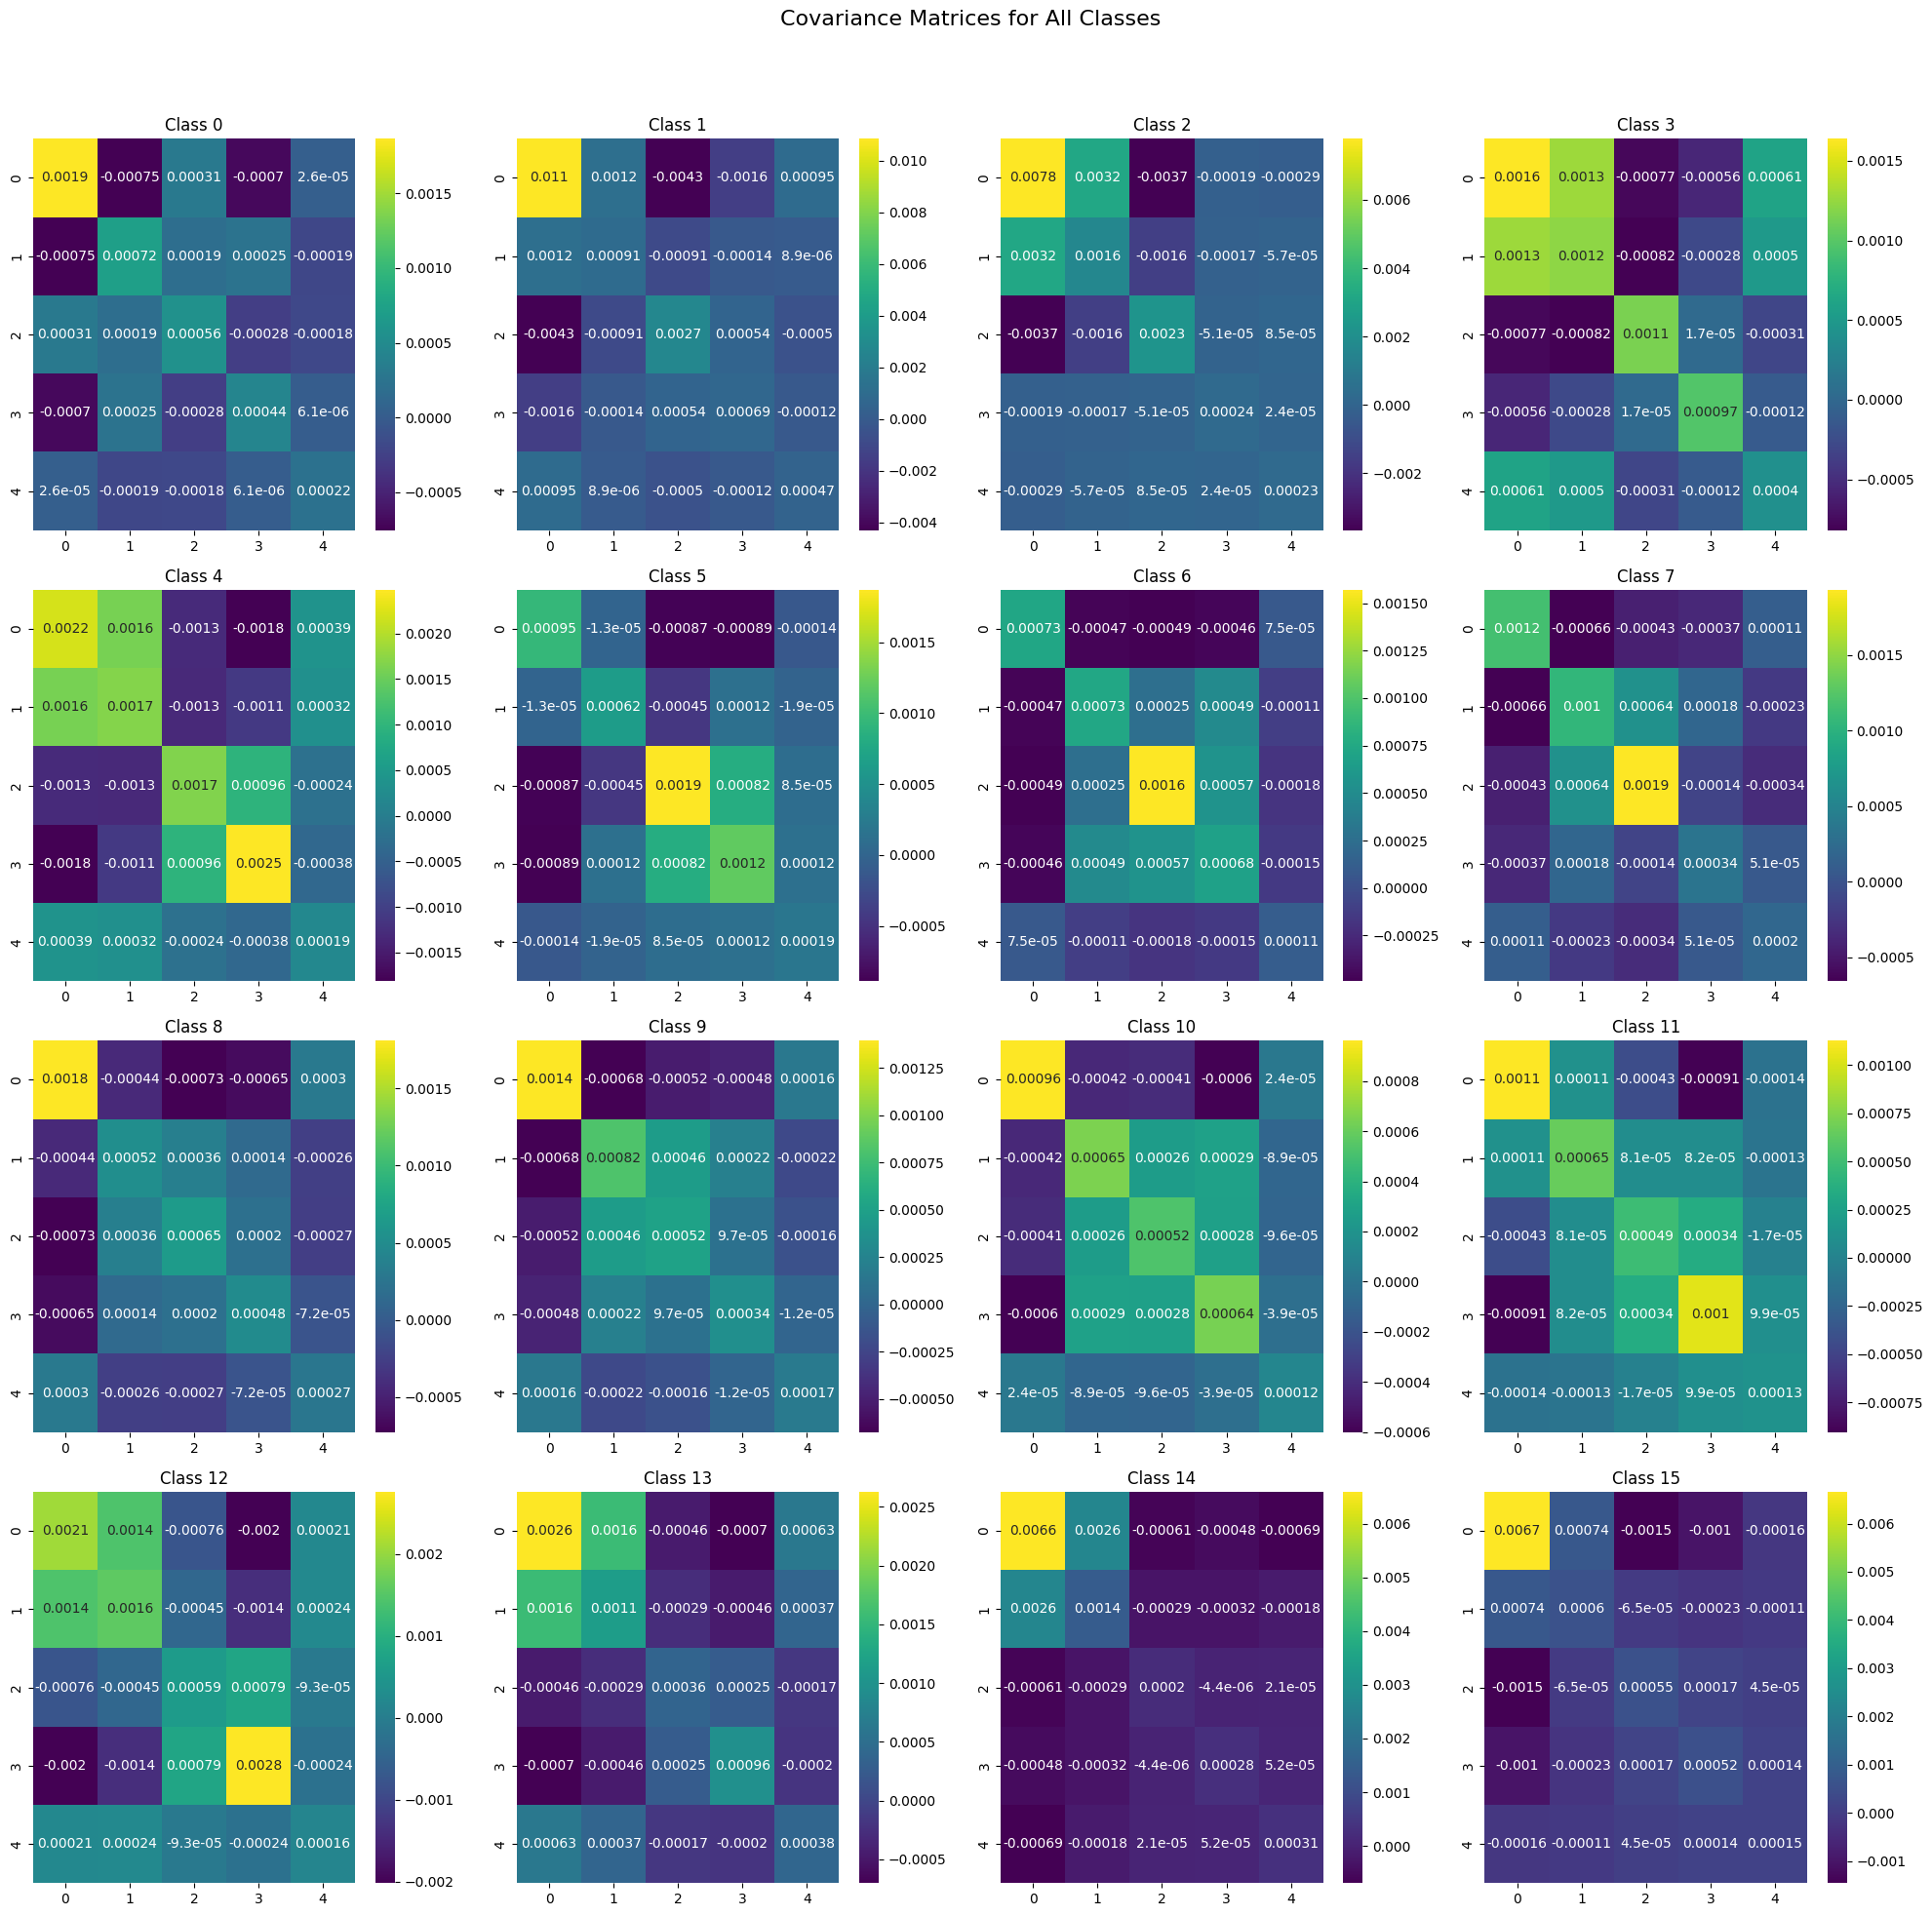

Mean vector - min: -0.2451896470461925, max: 0.2589566050412964, mean: 0.009572747788171654
Covariance matrix - min: -0.004300784630285966, max: 0.010854540152151594, mean: 0.000139437889752658


In [67]:
# Check if all diagonal elements of covariance matrices are non-negative
all_non_negative = True
for i in range(num_classes):
    diag_elements = np.diag(cov_matrix[i])
    if np.any(diag_elements < 0):
        print(f"Negative variance found in class {i}")
        all_non_negative = False
if all_non_negative:
    print("All classes have non-negative variances.")

# Visualize covariance matrices using heatmaps in a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle('Covariance Matrices for All Classes', fontsize=16)

for i in range(num_classes):
    ax = axs[i // 4, i % 4]
    sns.heatmap(cov_matrix[i], annot=True, fmt='.2g', cmap='viridis', ax=ax)
    ax.set_title(f'Class {i}')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Summary statistics for mean vectors and covariance matrices
mean_flattened = mean_matrix.flatten()
cov_flattened = cov_matrix.flatten()

print(f"Mean vector - min: {mean_flattened.min()}, max: {mean_flattened.max()}, mean: {mean_flattened.mean()}")
print(f"Covariance matrix - min: {cov_flattened.min()}, max: {cov_flattened.max()}, mean: {cov_flattened.mean()}")

#### Analysis of Template Building Results

##### Mean Vector Analysis
The mean vector summary statistics:
- **Minimum value:** -0.2451896470461925
- **Maximum value:** 0.2589566050412964
- **Average value:** 0.009572747788171654

These values are reasonable and indicate that the mean vectors are centered around zero, which is expected after PCA transformation. The range is not excessively large, suggesting that the data has been normalized appropriately.

##### Covariance Matrix Analysis
The covariance matrix summary statistics:
- **Minimum value:** -0.004300784630285966
- **Maximum value:** 0.010854540152151594
- **Average value:** 0.000139437889752658

The key points to consider:
- **Diagonal Elements:** The maximum value of approximately 0.0108 for the variances (diagonal elements) is within a reasonable range, indicating that there is a moderate spread in the data along the principal components.
- **Off-diagonal Elements:** The minimum value of approximately -0.0043 for the covariances (off-diagonal elements) suggests some negative correlations between principal components, which is typical in PCA.

##### Heatmap Visualization of Covariance Matrices
The heatmaps of the covariance matrices for all classes provide a visual confirmation:
- **Diagonal Dominance:** Most of the matrices show higher values on the diagonal, confirming that variances are higher than covariances.
- **Symmetry:** The matrices are symmetric, as expected for covariance matrices.
- **Low Off-diagonal Values:** Off-diagonal values are generally close to zero, indicating weak correlations between different principal components.

##### Conclusion
The results and visualizations suggest that the templates are correctly built and the values are within the expected ranges. The covariance matrices show the correct structure, and the mean vectors are properly centered.

### 3) Apply the template to make predictions
Compute the template prediction for each operation for all traces in the trace set: $p(k)=-\frac{1}{2} * \sum_{i=1}^{n\_traces}(t_i-\mu_k)*C_{inv}*(t_i-\mu_k)^T$, with $C_{inv}$, the inverted pooled covariance matrix, $m_k$, the mean of operation $k$. Once the probabilities for every traces is computed with every key hypothesis, compute the success rate of order from 1 to 16 for the test traceset and plot the result.

In [112]:
# Compute the inverted pooled covariance matrix
pooled_cov_matrix = np.mean(cov_matrix, axis=0)
inv_pooled_cov_matrix = np.linalg.inv(pooled_cov_matrix)

# Function to compute the template prediction
def compute_log_prob(trace, mean_vector, inv_cov_matrix):
    diff = trace - mean_vector
    return -0.5 * np.dot(np.dot(diff, inv_cov_matrix), diff.T)

# Initialize log probabilities array for each key hypothesis
P_k = np.zeros(16)

# Apply templates to the test traces
for trace_idx in range(test_data.shape[0]):
    projected_trace = projected_test_data[trace_idx]
    for key_guess in range(16):  # Adjusted loop to 16 key guesses
        class_label = key_guess
        p_kj = compute_log_prob(projected_trace, mean_matrix[class_label], inv_pooled_cov_matrix)
        P_k[key_guess] += p_kj

    # Print top 5 key guesses so far with consistent formatting
    top_5_guesses = " ".join([f"{k:02x}" for k in P_k.argsort()[-5:]])
    print(f"Trace {trace_idx + 1:4} -> Top 5 key guesses: {top_5_guesses}")

# Identify the best key guess
best_key_guess = P_k.argsort()[-1]
print(f"\nBest key guess: {hex(best_key_guess)}")

Trace    1 -> Top 5 key guesses: 0d 0c 08 01 0f
Trace    2 -> Top 5 key guesses: 07 00 09 08 01
Trace    3 -> Top 5 key guesses: 04 01 0c 09 08
Trace    4 -> Top 5 key guesses: 0b 09 0c 08 04
Trace    5 -> Top 5 key guesses: 0c 0b 09 04 08
Trace    6 -> Top 5 key guesses: 0b 0c 09 04 08
Trace    7 -> Top 5 key guesses: 09 0b 08 0c 04
Trace    8 -> Top 5 key guesses: 0c 0b 09 04 08
Trace    9 -> Top 5 key guesses: 05 0b 04 09 08
Trace   10 -> Top 5 key guesses: 05 04 0b 09 08
Trace   11 -> Top 5 key guesses: 04 05 0b 09 08
Trace   12 -> Top 5 key guesses: 07 0b 05 09 08
Trace   13 -> Top 5 key guesses: 0a 05 07 08 09
Trace   14 -> Top 5 key guesses: 0b 05 07 09 08
Trace   15 -> Top 5 key guesses: 04 05 0b 09 08
Trace   16 -> Top 5 key guesses: 0a 05 0b 09 08
Trace   17 -> Top 5 key guesses: 0a 05 0b 09 08
Trace   18 -> Top 5 key guesses: 0a 0b 05 08 09
Trace   19 -> Top 5 key guesses: 07 0b 05 09 08
Trace   20 -> Top 5 key guesses: 0a 0b 05 09 08
Trace   21 -> Top 5 key guesses: 0a 05 0

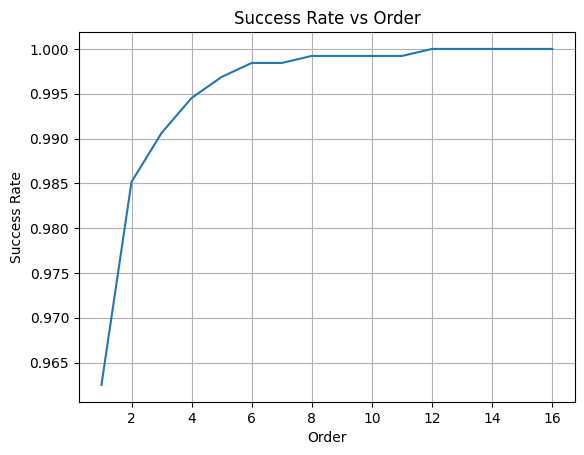

Success rate for order 1: 0.9625
Success rate for order 2: 0.9852
Success rate for order 3: 0.9906
Success rate for order 4: 0.9945
Success rate for order 5: 0.9969
Success rate for order 6: 0.9984
Success rate for order 7: 0.9984
Success rate for order 8: 0.9992
Success rate for order 9: 0.9992
Success rate for order 10: 0.9992
Success rate for order 11: 0.9992
Success rate for order 12: 1.0000
Success rate for order 13: 1.0000
Success rate for order 14: 1.0000
Success rate for order 15: 1.0000
Success rate for order 16: 1.0000


In [81]:
### Compute the success rate of order from 1 to 16 for the test trace set and plot the result
# Initialize a list to store the success rates
success_rates = []

# Function to compute the success rate
def compute_success_rate(P_k, true_key, order):
    sorted_indices = np.argsort(P_k)
    best_guesses = sorted_indices[-order:]
    return int(true_key in best_guesses)

# Calculate success rates for orders from 1 to 16
true_keys = test_targets  # Assuming test_targets contain the true ephemeral key parts
for order in range(1, 17):
    success_count = 0
    for trace_idx in range(test_data.shape[0]):
        a = projected_test_data[trace_idx]
        P_k = np.zeros(16)  # Ensure the size is correct here too
        for key_guess in range(16):
            class_label = key_guess
            p_kj = compute_log_prob(a, mean_matrix[class_label], inv_pooled_cov_matrix)
            P_k[key_guess] += p_kj
        success_count += compute_success_rate(P_k, true_keys[trace_idx], order)
    success_rate = success_count / test_data.shape[0]
    success_rates.append(success_rate)

# Plot the success rates
plt.plot(range(1, 17), success_rates)
plt.xlabel('Order')
plt.ylabel('Success Rate')
plt.title('Success Rate vs Order')
plt.grid(True)
plt.show()

# Print the success rates for each order
for order, rate in enumerate(success_rates, 1):
    print(f"Success rate for order {order}: {rate:.4f}")